In [2]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
sys.path.append('../Supplementary_scripts')
print(sys.path)
import numpy as np
import os
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import plotly.figure_factory as ff
import networkx as nx
from pyvis.network import Network
import zipfile 
from bioservices import KEGG
#from K_func import translate_ko_terms


'''
Data prep and feature mapping
'''

os.chdir('/Users/eliah/Documents/Master/Eliah-Masters/Datasets')
# Paths to your uploaded files
zip_file_path_KO = "terms_KO.zip"
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'
# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.02)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['gram'] = traits['gram'].str.lower()

# Mapping of oxygen levels to a simplified classification
Gramstaining_mapping = {
    'positive': 'positive',
    'negative': 'negative',
    'nan': 'nan'  
}
traits['gram'] = traits['gram'].map(Gramstaining_mapping)


# Handling missing values and aggregating by key
y = traits.dropna(subset=['gram']).groupby('key').agg({'gram': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"



['c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313', '', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\Pythonwin', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages', '../Data_Feature', '../Datasets', '../Supplementary_scripts', '../Data_Feature', '../Datasets', '../Supplementary_scripts']
Features with zero variance after filtering: 0


In [3]:
print(X_aligned.shape)
print(Y_aligned.shape)

(575, 7149)
(575,)


KO   K00001  K00002  K00003  K00004  K00005  K00007  K00008  K00009  K00010  \
key                                                                           
1       0.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
3       1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4       1.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
8       0.0     0.0     1.0     0.0     1.0     0.0     0.0     0.0     0.0   
14      1.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     1.0   

KO   K00011  ...  K22477  K22478  K22479  K22486  K22489  K22491  K22502  \
key          ...                                                           
1       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3       0.0  ...     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
4       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0  

C:\Users\eliah\AppData\Local\Temp\ipykernel_38292\287349031.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(X_aligned[column], Y_aligned)


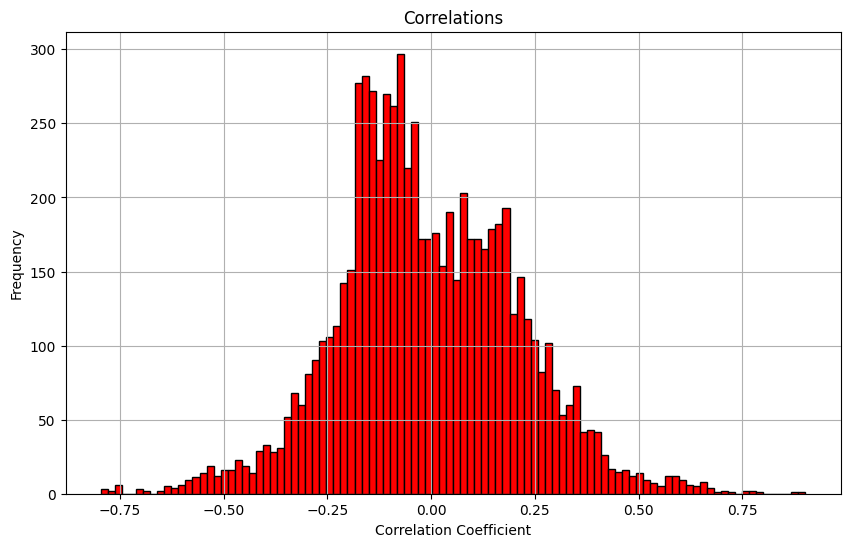

In [4]:
''' Calculating Pearsons coefficient'''

# Always look at data, right?
print(X_aligned.head())


'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Calculate Pearson correlation coefficients
corr_coefficients = [] # Collectes coefficents from X_aligned and Y_aligned calculations

# I should probably check how pearsons actually works


for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




Fitting 5 folds for each of 189 candidates, totalling 945 fits
Best parameters found: {'estimator': SVC(random_state=42), 'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'select_k__k': 500}
Best cross-validation score: 0.975
Matthews Correlation Coefficient: 0.9636321339376802


c:\Users\eliah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [5862] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\eliah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


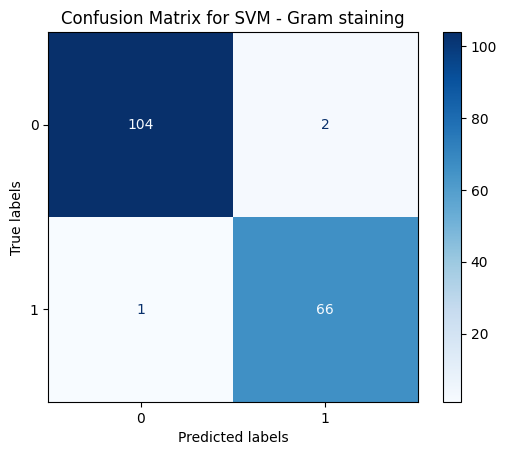

In [3]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need as needed  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k' : [10, 50, 100, 200, 300, 500, 1000],
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]


''' Grid search '''

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)


'''MCC shenanigans'''

mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")


# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for SVM - Gram staining')
plt.show()


Most selected KO terms for predicting oxygen trait in hierchical manner based on randomforest classifier:
This is model based feature importance (uses models own feature importance score to evaluate most important ones)
Index(['K07177', 'K06861', 'K01627', 'K00979', 'K06041', 'K07277', 'K11720',
       'K21273', 'K02535', 'K07091'],
      dtype='object', name='KO')


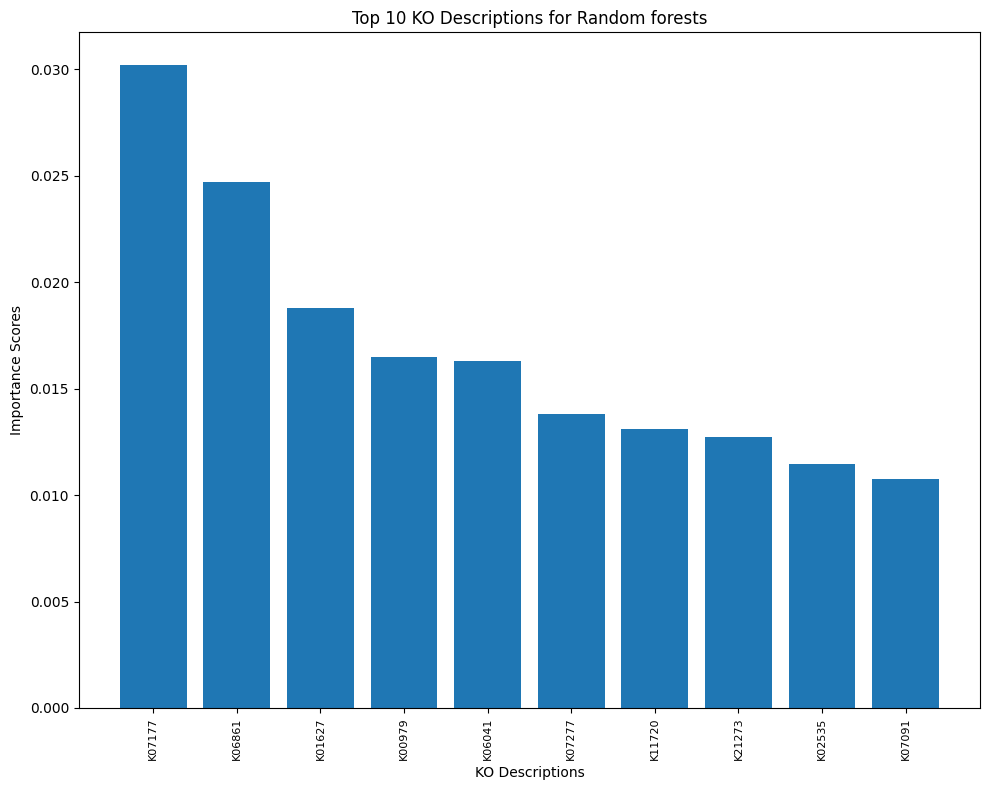

Most selected KO terms for predicting oxygen trait in hierchical manner based on logistic regression:
This is model based feature importance (uses model's coefficients as importance scores)
Index(['K01647', 'K09951', 'K04651', 'K00797', 'K03641', 'K20276', 'K07755',
       'K09772', 'K00333', 'K02523'],
      dtype='object', name='KO')


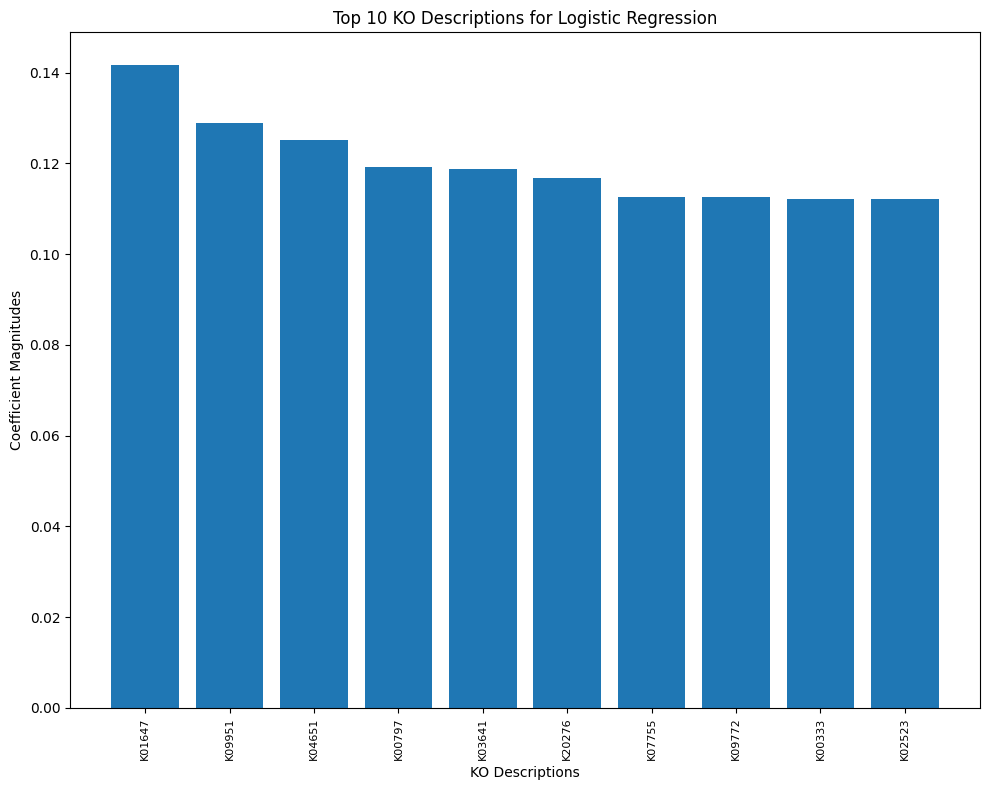

In [8]:
''' Model based feature importance score '''

#Fit a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_aligned, Y_aligned)

#Rank features by their importances
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 10 features
top_k_indices = sorted_indices[:10]
selected_features = X_aligned.columns[top_k_indices]

# Scores of selected features
sorted_scores = feature_importances[top_k_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner based on randomforest classifier:")
print("This is model based feature importance (uses models own feature importance score to evaluate most important ones)")
print(selected_features)

#Translate selected KO terms to their descriptions
translated_sorted_features = translate_ko_terms(list(selected_features))

# Prepare labels and scores for plotting
labels = [translated_sorted_features[ko] for ko in selected_features]
sorted_labels = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels)), sorted_scores)
plt.xticks(range(len(sorted_labels)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('Importance Scores')
plt.title('Top 10 KO Descriptions for Random forests')
plt.tight_layout()
plt.show()


''' For logsitc regression'''

#Fit a LogisticRegression model
lr_model = LogisticRegression()
lr_model.fit(X_aligned, Y_aligned)

#Rank features by their coefficients
lr_coefficients = lr_model.coef_[0]
sorted_indices_lr = np.argsort(np.abs(lr_coefficients))[::-1]

# Select the top 10 features
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

# Coefficients (importance) of selected features
sorted_scores_lr = lr_coefficients[top_k_indices_lr]

print("Most selected KO terms for predicting oxygen trait in hierchical manner based on logistic regression:")
print("This is model based feature importance (uses model's coefficients as importance scores)")
print(selected_features_lr)

#Translate selected KO terms to their descriptions
translated_sorted_features = translate_ko_terms(list(selected_features_lr))

# Prepare labels and scores for plotting
labels_lr = [translated_sorted_features[ko] for ko in selected_features_lr]
sorted_labels_lr = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels_lr)), np.abs(sorted_scores_lr))  # Use absolute value for visualization
plt.xticks(range(len(sorted_labels_lr)), translated_sorted_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('Coefficient Magnitudes')
plt.title('Top 10 KO Descriptions for Logistic Regression')
plt.tight_layout()
plt.show()


WARNING [bioservices.KEGG:130]:  The URL (http://rest.kegg.jp) provided cannot be reached.


Pathway matrix after renaming:
                                                     Citrate cycle (TCA cycle)  \
CS, gltA; citrate synthase [EC:2.3.3.1] (K01647)                            1   
cas2; CRISPR-associated protein Cas2 (K09951)                               0   
hypA, hybF; hydrogenase nickel incorporation pr...                          0   
speE, SRM, SPE3; spermidine synthase [EC:2.5.1....                          0   
tolB; TolB protein (K03641)                                                 0   
bapA; large repetitive protein (K20276)                                     0   
AS3MT; arsenite methyltransferase [EC:2.1.1.137...                          0   
sepF; cell division inhibitor SepF (K09772)                                 0   
nuoD; NADH-quinone oxidoreductase subunit D [EC...                          0   
ispB; octaprenyl-diphosphate synthase [EC:2.5.1...                          0   

                                                    Citrate cycle (TCA cycle

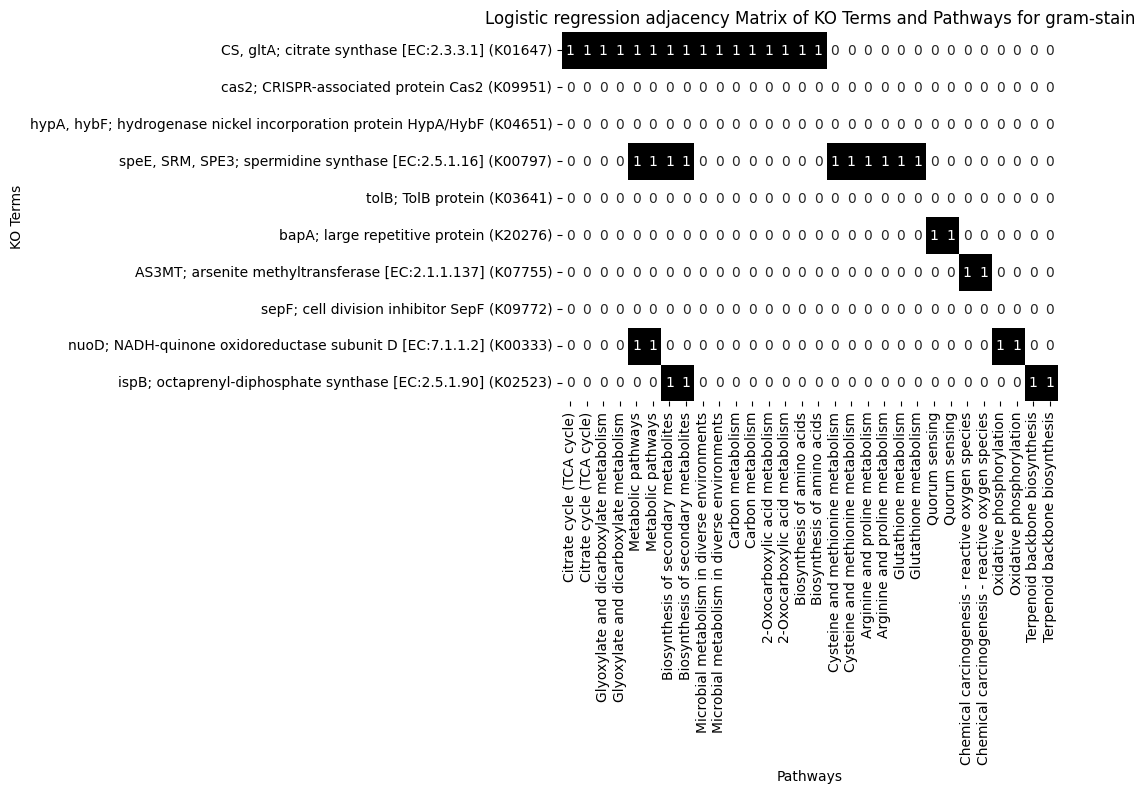

In [11]:
kegg = KEGG()

def translate_ko_terms(ko_terms):
    ko_descriptions = {}
    for ko in ko_terms:
        try:
            result = kegg.find("ko", ko)
            # The result can contain multiple lines if the term has multiple entries; split by newline
            first_line = result.split('\n')[0]
            # Each line is tab-separated with the format: entry_id, description
            _, description = first_line.split('\t', 1)
            ko_descriptions[ko] = description
        except Exception as e:
            print(f"Error retrieving information for {ko}: {e}")
            ko_descriptions[ko] = ko  # Use the KO term itself if the name can't be retrieved
    return ko_descriptions

def map_ko_to_pathways(ko_terms):
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = selected_features_lr
pathways = map_ko_to_pathways(selected_important_features)
translated_kos = translate_ko_terms(selected_important_features)  

# Creating the adjacency matrix with translated KO terms, including original KO term
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
pathway_names = {}
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_names[column] = pathway_name
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title('Logistic regression adjacency Matrix of KO Terms and Pathways for gram-stain')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Initialize a network graph
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading='Logistic regression Network of KO Terms and Pathways for gram-stain', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])

nt.save_graph("KO_GRAM_LR_OF.html")


In [4]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 negative    247
positive    155
Name: count, dtype: int64
Unique labels in Y_train: ['negative' 'positive']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 402
Number of labels in Y_train: 402


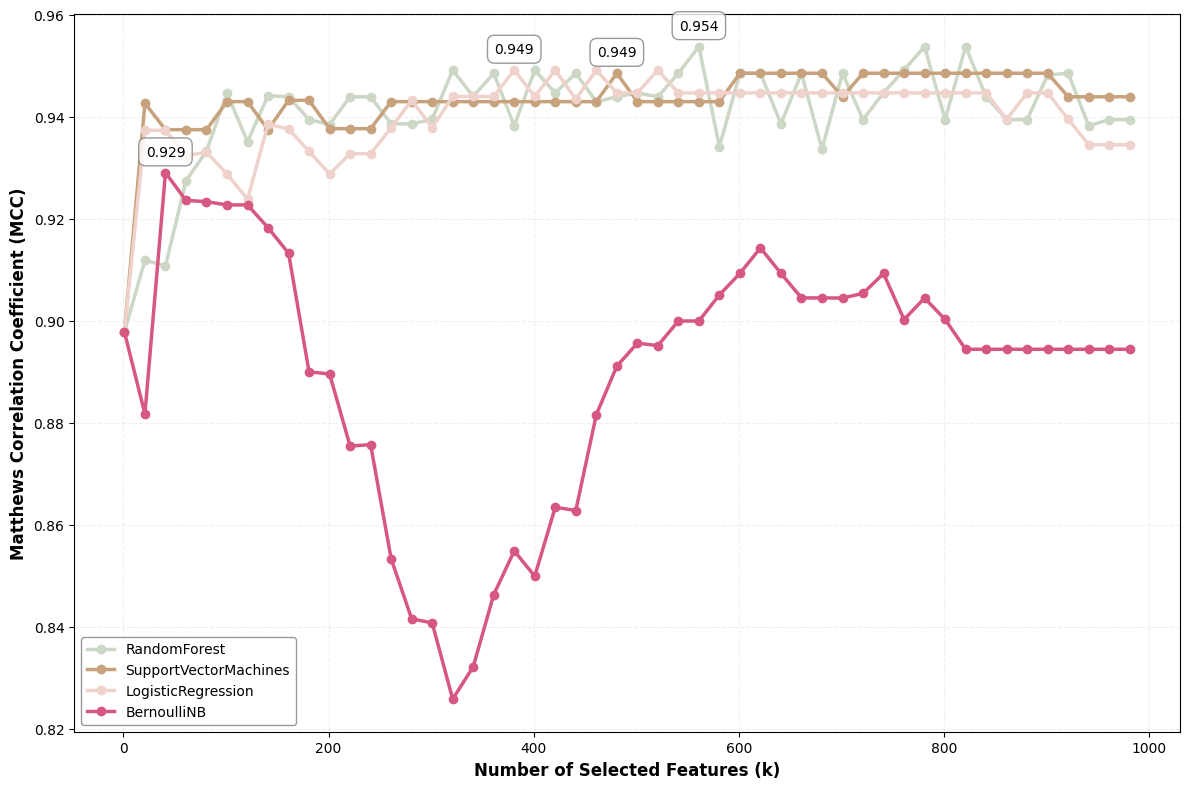

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Set the style for better visualization


# Define custom colors
COLORS = {
    'RandomForestClassifier': '#CCD7C5',
    'SupportVectorMachines': '#C7A27C',
    'LogisticRegression': '#EFD2CB',
    'BernoulliNB': '#D65780'
}

# Define the range of k values to explore
k_values = range(1, 1000, 20)

# Define estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(),
    'SupportVectorMachines': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store results for MCC
results = {name: {'mcc': []} for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    # Loop over each k value
    for k in k_values:
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        
        # Perform cross-validation for MCC
        mcc_scores = cross_val_score(
            pipeline, 
            X_train, 
            Y_train, 
            cv=cv, 
            scoring=make_scorer(matthews_corrcoef), 
            n_jobs=-1
        )
        results[name]['mcc'].append(mcc_scores.mean())

# Create the plot with improved styling
plt.figure(figsize=(12, 8))

# Plot each estimator's results
for name, scores in results.items():
    k_values_list = list(k_values)
    finite_mcc_scores = [score for score in scores['mcc'] if np.isfinite(score)]
    finite_k_values_mcc = [k for k, score in zip(k_values_list, scores['mcc']) 
                          if np.isfinite(score)]
    
    # Plot line with custom styling
    plt.plot(finite_k_values_mcc, finite_mcc_scores, 
            color=COLORS[name],
            marker='o', 
            markersize=6,
            linewidth=2.5,
            label=name.replace('Classifier', ''))
    
    # Add annotation for maximum score
    if finite_mcc_scores:
        max_mcc_score = max(finite_mcc_scores)
        max_mcc_index = finite_mcc_scores.index(max_mcc_score)
        best_k_mcc = finite_k_values_mcc[max_mcc_index]
        
        plt.annotate(f'{max_mcc_score:.3f}',
                    xy=(best_k_mcc, max_mcc_score),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', 
                            fc='white', 
                            alpha=0.8,
                            edgecolor='gray'),
                    fontsize=10)

# Customize the plot
plt.xlabel('Number of Selected Features (k)', fontsize=12, fontweight='bold')
plt.ylabel('Matthews Correlation Coefficient (MCC)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray')

# Add subtle background grid
plt.grid(True, linestyle='--', alpha=0.2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

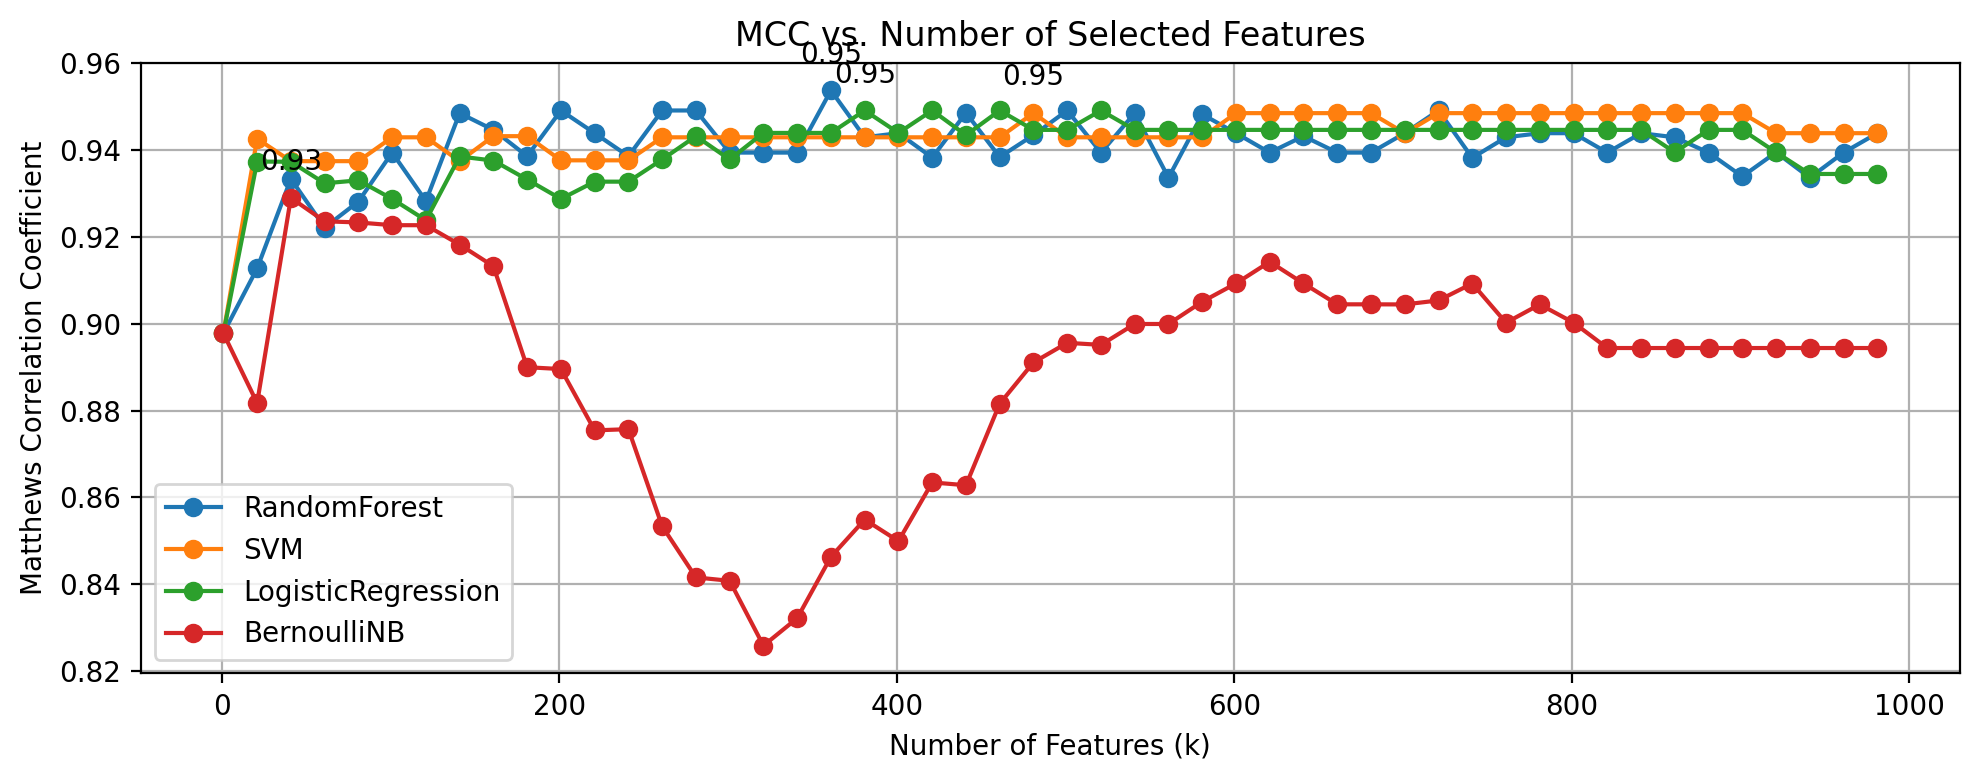

In [7]:
# Comparing MCC only

k_values = range(1, 1000, 20)

estimators = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Only keep MCC results
results = {name: [] for name in estimators}

cv = StratifiedKFold(n_splits=5)

for name, estimator in estimators.items():
    for k in k_values:
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('clf', estimator)
        ])
        mcc_scores = cross_val_score(
            pipeline, X_train, Y_train,
            cv=cv,
            scoring=make_scorer(matthews_corrcoef),
            n_jobs=-1
        )
        results[name].append(mcc_scores.mean())

# Plot MCC
plt.figure(figsize=(10, 4),dpi=200)
for name, mccs in results.items():
    ks = list(k_values)
    plt.plot(ks, mccs, marker='o', label=name)
    # annotate best point
    best_idx = np.nanargmax(mccs)
    plt.annotate(f'{mccs[best_idx]:.2f}',
                 (ks[best_idx], mccs[best_idx]),
                 textcoords='offset points', xytext=(0,10), ha='center')

plt.title('MCC vs. Number of Selected Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Matthews Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Pearson Correlation Coefficient: 0.294


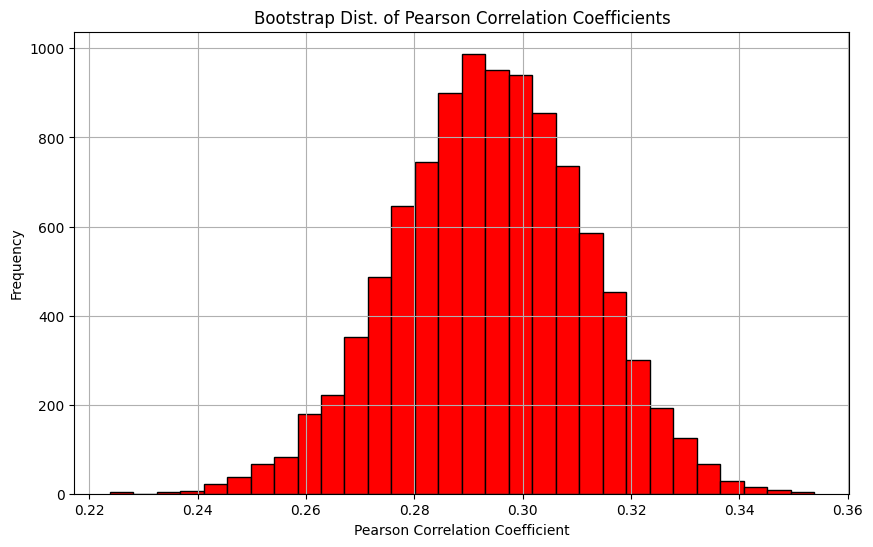

In [ ]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''


lr_model = LogisticRegression(solver='lbfgs', penalty="l2")
rf_model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_split=5, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")
#print(f"P-Value: {p_value:.3f}")

# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()